# ML Zoomcamp 2023 &ndash; Midterm Project

The _Heart failure clinical records_ dataset contains the medical records of 299 patients who had heart failure, collected during their follow-up period, where each patient profile has 13 clinical features. The data set can be retrieved from the UCI Machine Learning Repository at the link, [Heart failure clinical records](http://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records). The research article for the data set can be accessed at the link, [Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone](https://www.semanticscholar.org/paper/Machine-learning-can-predict-survival-of-patients-Chicco-Jurman/e64579d8593140396b518682bb3a47ba246684eb) (link to pdf of article [here](https://bmcmedinformdecismak.biomedcentral.com/counter/pdf/10.1186/s12911-020-1023-5.pdf)).

* [Data preparation](#Data-preparation)
* [Data transformation](#Data-transformation)
    * [Modeling with logistic regression, decision trees and random forests](#Modeling-with-logistic-regression,-decision-trees-and-random-forests)
    * [Modeling with XGBoost](#Modeling-with-XGBoost)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

## Data preparation

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.rename(columns={'DEATH_EVENT': 'death_event'}, inplace=True)
for col in ['anaemia', 'diabetes', 'high_blood_pressure', 'smoking']:
    df[col].replace(to_replace=[0, 1], value=['No', 'Yes'], inplace=True)
df.sex.replace(to_replace=[0, 1], value=['Female', 'Male'], inplace=True)
df.head().T

,0,1,2,3,4
age,75.0,55.0,65.0,50.0,65.0
anaemia,No,No,No,Yes,Yes
creatinine_phosphokinase,582,7861,146,111,160
diabetes,No,No,No,No,Yes
ejection_fraction,20,38,20,20,20
high_blood_pressure,Yes,No,No,No,No
platelets,265000.0,263358.03,162000.0,210000.0,327000.0
serum_creatinine,1.9,1.1,1.3,1.9,2.7
serum_sodium,130,136,129,137,116
sex,Male,Male,Male,Male,Female


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    object 
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    object 
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    object 
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    object 
 10  smoking                   299 non-null    object 
 11  time                      299 non-null    int64  
 12  death_event               299 non-null    int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 30.5+ KB


## Data transformation

In [4]:
X = df.drop('death_event', axis=1)
y = df.death_event

In [5]:
X_full_train, X_test, y_full_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_full_train, y_full_train, test_size=0.25, random_state=1)

In [6]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [7]:
def data_transformation(X_train, X_val, X_test):
    X_train_dicts = X_train.to_dict(orient='records')
    X_val_dicts = X_val.to_dict(orient='records')
    X_test_dicts = X_test.to_dict(orient='records')
    dv = DictVectorizer(sparse=True)
    X_cat_tr = dv.fit_transform(X_train_dicts)
    feature_names = list(dv.get_feature_names_out())
    X_cat_val = dv.transform(X_val_dicts)
    X_cat_test = dv.transform(X_test_dicts)
    return X_cat_tr, X_cat_val, X_cat_test, feature_names

In [8]:
X_cat_train, X_cat_val, X_test_val, feature_names = data_transformation(X_train, X_val, X_test)

### Modeling with logistic regression, decision trees and random forests

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    rf = RandomForestClassifier(n_estimators=200, min_samples_leaf=5, max_depth=8, random_state=1)
    dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=1)

    lr.fit(X_cat_train, y_train)
    dt.fit(X_cat_train, y_train)
    rf.fit(X_cat_train, y_train)

    y_pred_lr = lr.predict(X_cat_val)
    y_pred_dt = dt.predict(X_cat_val)
    y_pred_rf = rf.predict(X_cat_val)

    auc_result_lr = roc_auc_score(y_val, y_pred_lr)
    auc_result_dt = roc_auc_score(y_val, y_pred_dt)
    auc_result_rf = roc_auc_score(y_val, y_pred_rf)

    f1_score_lr = f1_score(y_val, y_pred_lr)
    f1_score_dt = f1_score(y_val, y_pred_dt)
    f1_score_rf = f1_score(y_val, y_pred_rf)

print(f'F1 score using logistic regression: {f1_score_lr.round(3):>8}')
print(f'AUC using logistic regression: {auc_result_lr.round(3):>13}')
print()
print(f'F1 score using decision trees: {f1_score_dt.round(3):>13}')
print(f'AUC using decision trees: {auc_result_dt.round(3):>18}')
print()
print(f'F1 score using random forests: {f1_score_rf.round(3):>13}')
print(f'AUC using random forests: {auc_result_rf.round(3):>18}')

F1 score using logistic regression:    0.773
AUC using logistic regression:         0.816

F1 score using decision trees:         0.826
AUC using decision trees:              0.859

F1 score using random forests:         0.864
AUC using random forests:              0.886


### Modeling with XGBoost

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    dtrain = xgb.DMatrix(X_cat_train, label=y_train, feature_names=feature_names)
    dval = xgb.DMatrix(X_cat_val, label=y_val, feature_names=feature_names)

In [11]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [12]:
%%capture output
watchlist = [(dtrain, 'train'), (dval, 'val')]
model = xgb.train(xgb_params, dtrain, evals=watchlist, num_boost_round=100)

In [13]:
def parse_xgb_output(output):
    results = []
    
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
        
    df_results = pd.DataFrame(results, columns=['num_iter', 'logloss_train', 'logloss_val'])
    return df_results

In [14]:
df_score = parse_xgb_output(output)

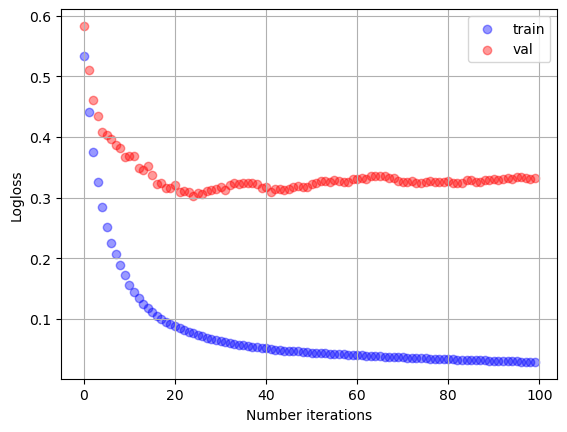

In [15]:
fig, ax = plt.subplots()
ax.scatter(df_score.num_iter, df_score.logloss_train, color='blue', label='train', alpha=0.4)
ax.scatter(df_score.num_iter, df_score.logloss_val, color='red', label='val', alpha=0.4)
ax.set_xlabel('Number iterations')
ax.set_ylabel('Logloss')
ax.legend(loc='best')
plt.grid(True)

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    y_pred = (model.predict(dval) > 0.4).astype(int)
    xgb_auc_result = roc_auc_score(y_val, y_pred)
    f1_score_result = f1_score(y_val, y_pred)
print(f'AUC using XGBoost: {xgb_auc_result.round(3):>13}')
print(f'F1 score using XGBoost: {f1_score_result.round(3):>8}')

AUC using XGBoost:         0.889
F1 score using XGBoost:    0.857
